# Time Series Analysis Challenge
Using a different time series data set (either from FRED or elsewhere, go about the process of time series modeling. Specifically generate the following things:

1. Plot the time series, along with any logical or necessary differences to get a stationary dataset
2. Generate and interpret a PACF for the time series (and/or its differences)
3. Generate 5 ARIMA specifications and evaluate their efficacy at modeling your data
4. Finally choose one specification and make the case for that as a logical model for your dataset.

## Importing the Data
The stock chosen was Ferrari, and the daily open, high, low, close, and volumne was imported from the Alpaca Securities API. 

In [35]:
import alpaca_trade_api as tradeapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import autocorrelation_plot
from sklearn import metrics

%matplotlib inline

In [2]:
api = tradeapi.REST('PK5ZLGMKZ4LUIPPTQREM', 'mPGGruw0J5TzflIiWgndeBNh6wVUmFVYnjdH847r', 'https://paper-api.alpaca.markets')

# Daily OHLCV dataframe for Ferrari
race_daily = api.polygon.historic_agg('day', 'RACE', limit=1000).df

race_daily.head()

,open,high,low,close,volume
day,,,,,
2015-11-20 00:00:00-05:00,47.87,48.4900,47.6201,48.08,542692
2015-11-23 00:00:00-05:00,48.10,48.2899,45.9800,46.00,1389215
2015-11-24 00:00:00-05:00,46.00,46.4600,44.6500,46.28,1036703
2015-11-25 00:00:00-05:00,46.50,46.8300,45.5000,45.66,868893
2015-11-27 00:00:00-05:00,45.59,46.4200,45.4000,46.06,285304


## 1. Plot the Time Series
Below is the stock chart of all the closing prices for Ferrari for the last 1000 trading days. While this chart is very informative, for the purposes of our model we need to have the time series converted to be stationary. This is plotted in chart 2 below. 

Stationary means that the statistical properties of a process generating a time series does not change over time. This means the wasy it changes over times does not change. In the case below it is the daily prices difference, which has a constant slope. This is important as stationary processes are easier to analyze and model.

c:\users\andre\desktop\python\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


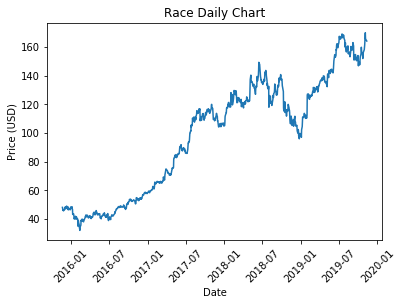

In [3]:
# Plot stock close prices
race_daily['date'] = race_daily.index.date

plt.plot(race_daily['date'], race_daily['close'])
plt.xticks(rotation=45)
plt.title('Race Daily Chart')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.show()

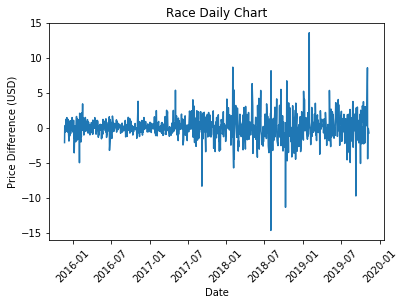

In [4]:
# Update the closing prices to be stationary
race_daily['close_diff'] = race_daily['close'] - race_daily['close'].shift()

# Plot stationary closing prices
plt.plot(race_daily['date'], race_daily['close_diff'])

plt.title('Race Daily Chart')
plt.xticks(rotation=45)
plt.ylabel('Price Difference (USD)')
plt.xlabel('Date')
plt.show()

## 2. PACF
ACF is auto-correlation function which gives us values of auto-correlation of a series with its lagged values. It describes how well the present value of a series is related with its past values. PACF is a partial auto-correlation function. It finds correlation of residuals with the next lag value. The closing price times series show a strong correlation to one prior date, while the differences show no real autocorrelation. Based on these charts, the ideal ARIMA parameters could be (1, 0, 0). These parameters will be explained below in the ARIMA modeling portion. 

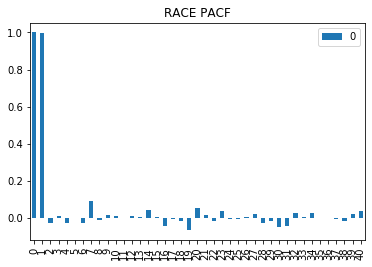

In [5]:
x_acf = pd.DataFrame(pacf(race_daily['close']))
x_acf.plot(kind='bar')
plt.title("RACE PACF")
plt.show()

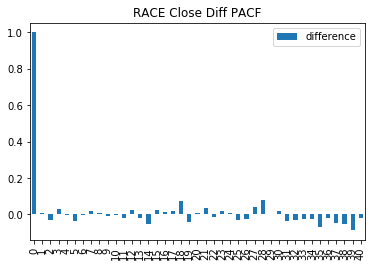

In [6]:
x_acf = pd.DataFrame(pacf(race_daily['close_diff'][1:]))
x_acf.plot(kind='bar')
plt.title("RACE Close Diff PACF")
plt.legend(['difference'])
plt.show()

## 3. ARIMA
For this challenge lets see if we can produce the best model for the stock price in the short term. IE 20 days or less. The autocorrelation plot below shows that the ideal number of lag days is WHAT.

ARIMA model is a class of statistical models for analyzing and forecasting time series data. It stands for AutoRegressive Integrated Moving Average. Lets breakdown each element below:

1. AR: Autoregression. It is a model that uses the dependant relationship between an observation and number of lagged observations.
2. I: Integrated. Use of differencing of raw observations.
3. MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to the lagged observations. 

Each of these components apply to a specific parameter (p, d, q)

c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  999
Model:                 ARIMA(3, 1, 0)   Log Likelihood               -2017.105
Method:                       css-mle   S.D. of innovations              1.822
Date:                Mon, 11 Nov 2019   AIC                           4044.210
Time:                        10:48:50   BIC                           4068.744
Sample:                             1   HQIC                          4053.535
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1161      0.058      1.991      0.047       0.002       0.230
ar.L1.D.close     0.0080      0.032      0.253      0.800      -0.054       0.070
ar.L2.D.close    -0.0291      0.032     

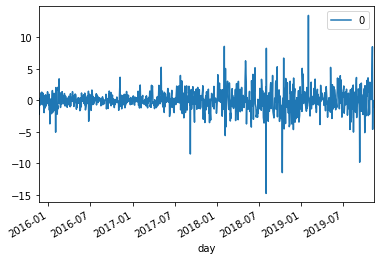

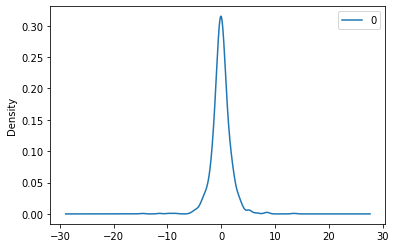

                0
count  999.000000
mean     0.000047
std      1.823368
min    -14.782884
25%     -0.801772
50%     -0.046439
75%      0.786980
max     13.508475


In [10]:
model = ARIMA(race_daily['close'], order=(3, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [11]:
model = ARIMA(race_daily['close'], order=(3, 0, 0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1000
Model:                     ARMA(3, 0)   Log Likelihood               -2025.018
Method:                       css-mle   S.D. of innovations              1.827
Date:                Mon, 11 Nov 2019   AIC                           4060.036
Time:                        10:48:51   BIC                           4084.575
Sample:                             0   HQIC                          4069.362
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         104.3547     45.838      2.277      0.023      14.514     194.195
ar.L1.close     1.0111      0.028     36.124      0.000       0.956       1.066
ar.L2.close    -0.0360      0.042     -0.847    

In [12]:
model = ARIMA(race_daily['close'], order=(1, 0, 1))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1000
Model:                     ARMA(1, 1)   Log Likelihood               -2025.309
Method:                       css-mle   S.D. of innovations              1.828
Date:                Mon, 11 Nov 2019   AIC                           4058.617
Time:                        10:48:51   BIC                           4078.248
Sample:                             0   HQIC                          4066.078
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         104.2403     45.295      2.301      0.022      15.463     193.018
ar.L1.close     0.9994      0.001   1306.540      0.000       0.998       1.001
ma.L1.close     0.0120      0.033      0.371    

In [13]:
model = ARIMA(race_daily['close'], order=(1, 0, 0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                              ARMA Model Results                              
Dep. Variable:                  close   No. Observations:                 1000
Model:                     ARMA(1, 0)   Log Likelihood               -2025.377
Method:                       css-mle   S.D. of innovations              1.828
Date:                Mon, 11 Nov 2019   AIC                           4056.754
Time:                        10:48:51   BIC                           4071.478
Sample:                             0   HQIC                          4062.350
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         104.2457     45.554      2.288      0.022      14.961     193.530
ar.L1.close     0.9994      0.001   1341.093      0.000       0.998       1.001
                                    Roots       

c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
model = ARIMA(race_daily['close'], order=(1, 1, 0))
model_fit = model.fit()
print(model_fit.summary())
print('Residuals Description')
print(model_fit.resid.describe())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  999
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -2018.052
Method:                       css-mle   S.D. of innovations              1.824
Date:                Mon, 11 Nov 2019   AIC                           4042.103
Time:                        10:48:51   BIC                           4056.823
Sample:                             1   HQIC                          4047.698
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1162      0.058      2.000      0.046       0.002       0.230
ar.L1.D.close     0.0069      0.032      0.217      0.829      -0.055       0.069
                                    Root

c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)



Residuals Description
count    999.000000
mean       0.000015
std        1.825098
min      -14.749940
25%       -0.789209
50%       -0.031502
75%        0.785448
max       13.479923
dtype: float64


## Auto ARIMA
While randomly plugging number above is fun and all, there is a more efficient method to find the ideal arima parameters. The auto arima model below will search for the best model between p and q values of 1-20. The models will test both stationary and non stationary time series to see which has the best fit. As identified below the best fitting ARIMA model had the parameters of (1, 0, 0) similar to the model above. 

In [18]:
from pmdarima import auto_arima
stepwise_model = auto_arima(df, start_p=1, start_q=1,
                           max_p=20, max_q=20, m=12,
                           start_P=0, seasonal=True,
                           d=None, max_d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())
print(stepwise_model)

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=4046.796, BIC=4071.275, Fit time=3.279 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=6431.473, BIC=6441.265, Fit time=0.052 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=4361.421, BIC=4381.004, Fit time=1.486 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=5533.502, BIC=5553.085, Fit time=1.987 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=4048.083, BIC=4077.457, Fit time=4.741 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=4612.263, BIC=4631.846, Fit time=0.345 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=4048.101, BIC=4077.475, Fit time=17.596 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=4048.505, BIC=4082.775, Fit time=16.190 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=4048.036, BIC=4077.410, Fit time=5.356 seconds
Fit ARIMA: order=(1, 0, 0)

## 4. Comparison of AIC
The smallest AIC value will be compared to the second smallest below. The smaller the ratio the greater differences. The ratio below indicates that there is no significant differences between the two orders. 

In [22]:
x = np.exp((4043.979-4045.068)/2)
print(x)

0.5801317767237057


## Predicting Stock Price
The stock price data will be split between a test and training set. The training set will consist of 95 percent of the price action, and the test set will be of the last 50 days. The results will be explained in the conclusion section below.

In [61]:
df= race_daily['close']
X = df.values
size = int(len(X) * 0.95)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

mse = metrics.mean_squared_error(test, predictions)
print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % np.sqrt(mse))
mae = metrics.mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % mae)
mape = np.mean(np.abs((test - predictions) / test)) * 100
print('Test MSE: %.3f' % mape)

c:\users\andre\desktop\python\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
c:\users\andre\desktop\python\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)


Test MSE: 7.012
Test RMSE: 2.648
Test MAE: 1.897
Test MSE: 3.764


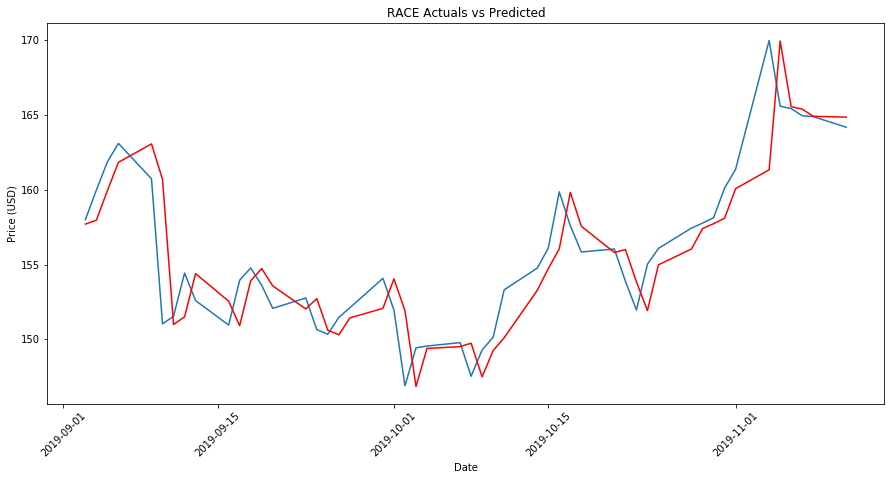

In [62]:
# Plot the stock price prediction vs actual
plt.figure(figsize=(15, 7))
plt.plot(df.index[-50:], test)
plt.plot(df.index[-50:], predictions, color='red')

plt.title('RACE Actuals vs Predicted')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.show()

## Conclusion
As shown above in the RACE actuals vs Predicted, the predicted stock price for the most part was very well fitted to the actuals. The MSE, RSME, MAE, and MAPE all have extremely low values, which indicate a great fitting estimator. Out of the four the best indicator is MAE. MAE stands for mean absolute error and is calculated as an average of absolute differences between the target values and the predictions. The MAE score is linear meaning that individual differences are weighted equally. This metric penalizes huge errors but is not sensitive to outiers. The next step would be to use ARIMA for backtesting stockmarket trades. 